source: https://medium.com/p/2c6c657f8fc0 

In [ ]:
# choose dataset from 'NPOV', 'WNC', 'CrowS-Pairs', 'Stereo', 'Mixed'
dataset = 'NPOV'

# Imports and Set-up

In [ ]:
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load dataset

In [ ]:
# Fields
source_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets"
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train=dataset + '_train.csv', validation=dataset + '_valid.csv', test=dataset + '_test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
for ((text, text_len), labels), _ in train_iter:
  break

In [ ]:
text

tensor([[    0,   565],
        [ 3362,    14],
        [32270,  5710],
        [ 4721,     0],
        [ 6266, 48081],
        [    0,  1894],
        [  720,     0],
        [ 6977,   459],
        [    0,  1492],
        [ 6266,     0],
        [10927, 21644],
        [57952,   178],
        [  468,     0],
        [ 6266,     0],
        [ 4787,  9929],
        [  570,  9744],
        [ 6266,     0],
        [13496,  1405],
        [ 6266,     0],
        [  627,     0],
        [37882,  9929],
        [    0,   550],
        [  279,     0],
        [  148, 22650],
        [   52,  3863],
        [ 6266, 21430],
        [    0,   789],
        [24531,  2272],
        [ 4787,  9929],
        [ 7175,  9929],
        [22500,  1684],
        [ 6266,  4875]], device='cuda:0')

# Build model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.3)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.to('cpu'), batch_first=True, enforce_sorted=False) # added .to('cpu') to avoid an error
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# Load Functions

In [ ]:
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# Training

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for ((text, text_len), labels), _ in train_loader:  # it should be just text instead of text
                                                                      # but we keep text to not change the rest of the code         
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for ((text, text_len), labels), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/bilstm_model_' + dataset + '.pt', model, optimizer, best_valid_loss)
    
    print('Finished Training!')

In [ ]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# load_checkpoint(destination_folder + '/bilstm_model_' + dataset + '.pt', model, optimizer) # comment this if you wannt to trainn the model from zero

train(model=model, optimizer=optimizer, num_epochs=5)

Epoch [1/5], Step [125/1250], Train Loss: 0.6440, Valid Loss: 0.6775
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bilstm_model_Mixed.pt
Epoch [1/5], Step [250/1250], Train Loss: 0.6849, Valid Loss: 0.6715
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bilstm_model_Mixed.pt
Epoch [2/5], Step [375/1250], Train Loss: 0.5611, Valid Loss: 0.6984
Epoch [2/5], Step [500/1250], Train Loss: 0.6467, Valid Loss: 0.6772
Epoch [3/5], Step [625/1250], Train Loss: 0.4056, Valid Loss: 0.9398
Epoch [3/5], Step [750/1250], Train Loss: 0.5148, Valid Loss: 0.7979
Epoch [4/5], Step [875/1250], Train Loss: 0.2436, Valid Loss: 1.1677
Epoch [4/5], Step [1000/1250], Train Loss: 0.2888, Valid Loss: 1.1805
Epoch [5/5], Step [1125/1250], Train Loss: 0.1751, Valid Loss: 1.5130
Epoch [5/5], Step [1250/1250], Train Loss: 0.1379, Valid Loss: 1.4481
Finished Training!


# Evaluation

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bilstm_model_NPOV.pt
Classification Report:
remember: 1 = BIASED, 0 = UNBIASED
              precision    recall  f1-score   support

           1     0.6816    0.5122    0.5849     18138
           0     0.6097    0.7611    0.6770     18161

    accuracy                         0.6367     36299
   macro avg     0.6457    0.6366    0.6310     36299
weighted avg     0.6456    0.6367    0.6310     36299



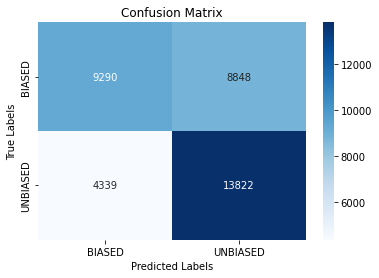

In [ ]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len), labels), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print('remember: 1 = BIASED, 0 = UNBIASED')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    ax.yaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/bilstm_model_' + dataset + '.pt', best_model, optimizer)
evaluate(best_model, test_iter)